# Project 3: Convolutional Neural Networks and Image Classification

Ash Rai <br>
CSC 675 <br>
Spring 2022

<b> Note: There is a separate detailed report submitted as a PDF </b>

## 1. Baseline Model

### 1.1 Defining the problem and assembling a dataset

#### Data Description
<b>CIFAR-100</b>: is a dataset of 50,000 32x32 color training images and 10,000 test images, labeled over 100 fine-grained classes that are grouped into 20 coarse-grained classes

#### Problem
The problem at hand was a classification problem, in an attempt to assign one of the 100 available classes to the images.

#### Importing Dataset

In [1]:
from tensorflow.keras.datasets import cifar100
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from keras import layers
from keras import models

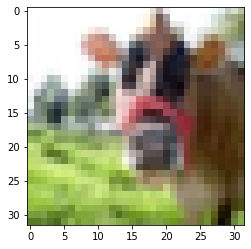

In [3]:
picture = x_train[0]
plt.imshow(picture, cmap=plt.cm.binary)
plt.show()

### 1.2 Choosing a measure of success

The dataset provides a class-balanced, single label classification problem. As such, the measure of success chosen was accuracy. 

### 1.3 Deciding on an evaluation protocol

Since there is enough data available, I opted to go for a hold-out validation as the evaluation protocol. I decided to set apart 5000 data points from the training set for validation, and the remaining 45000 images to train the model. The dataset itself comes with additional 10000 testing images, which were left out of the training process, and only used for final testing purpose.

### 1.4 Preparing the data

Preparing the dataset was a two stage process. 
1. On the image side, the images had to be normalized. This included subtracting the tensor mean for each feature, and dividing the tensor by the standard deviation. 
2. On the labels end, one-hot encoding was done to convert the discrete labeling into a categorical label. 

No additional preprocessing or feature engineering was necessary.


In [4]:
# Normalizing Dataset
train_images_processed = x_train - x_train.mean(axis=0)
train_images_processed = x_train / train_images_processed.std(axis=0)

test_images_processed = x_test - x_test.mean(axis=0)
test_images_processed = x_test / test_images_processed.std(axis=0)

In [5]:
# One-hot encoding
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(y_train)
one_hot_test_labels = to_categorical(y_test)

Setting aside validation set

In [6]:
x_val = train_images_processed[:5000]
partial_x_train = train_images_processed[5000:]
y_val = one_hot_train_labels[:5000]
partial_y_train = one_hot_train_labels[5000:]

### 1.5 Developing a model that does better than a baseline


Developing a basic CNN

In [117]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(100, activation='softmax'))

In [118]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2048)            

Defining the measure of success

In [119]:
from keras import optimizers

model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

In [122]:
history = model.fit(partial_x_train,
partial_y_train,
epochs=20,
batch_size=1000,
validation_data=(x_val, y_val))

Epoch 1/20
45/45 [==============================] - 2s 34ms/step - loss: 4.3362 - accuracy: 0.0512 - val_loss: 4.3254 - val_accuracy: 0.0620
Epoch 2/20
45/45 [==============================] - 1s 31ms/step - loss: 3.7925 - accuracy: 0.1318 - val_loss: 3.5408 - val_accuracy: 0.1668
Epoch 3/20
45/45 [==============================] - 1s 31ms/step - loss: 3.4654 - accuracy: 0.1880 - val_loss: 3.4050 - val_accuracy: 0.1858
Epoch 4/20
45/45 [==============================] - 1s 31ms/step - loss: 3.2272 - accuracy: 0.2302 - val_loss: 3.2437 - val_accuracy: 0.2156
Epoch 5/20
45/45 [==============================] - 1s 31ms/step - loss: 3.0210 - accuracy: 0.2660 - val_loss: 2.9754 - val_accuracy: 0.2678
Epoch 6/20
45/45 [==============================] - 1s 31ms/step - loss: 2.8520 - accuracy: 0.3024 - val_loss: 3.1128 - val_accuracy: 0.2566
Epoch 7/20
45/45 [==============================] - 1s 31ms/step - loss: 2.6875 - accuracy: 0.3341 - val_loss: 2.8905 - val_accuracy: 0.3024
Epoch 8/20
45

Evaluating Loss

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
def draw_loss_graph():
    sns.set_theme(style="darkgrid")

    plt.figure(figsize=(10,10))
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Evaluating Accuracy

In [15]:
def draw_accuracy_graph():
    plt.clf()
    plt.figure(figsize=(10,10))
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(val_acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

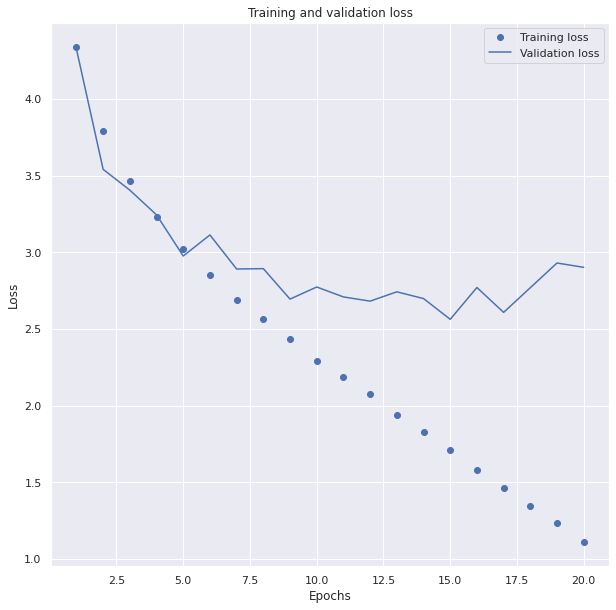

In [123]:
draw_loss_graph()

<Figure size 432x288 with 0 Axes>

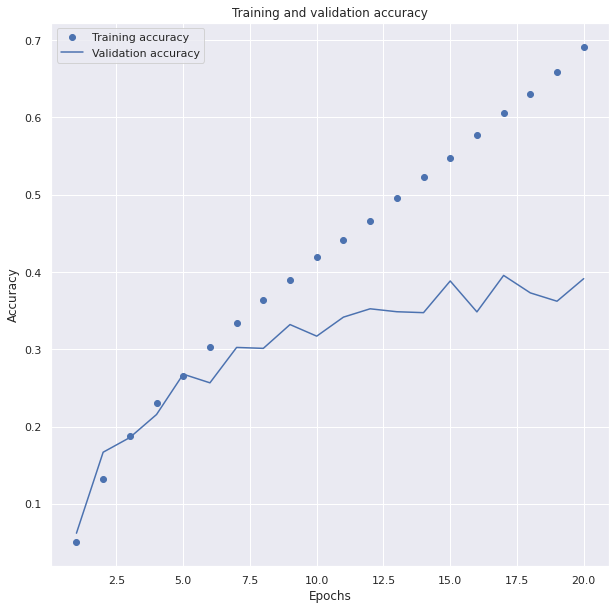

In [124]:
draw_accuracy_graph()

### 1.6 Scaling up: developing a model that overfits

Further improvement of the initial model to improve accuracy, although expecting an overfitting, consisted of 3 main steps:
1. Adding layers - Additional convolutional layers as well as max-pool layers were added to the network for additional statistical power.
2. Making the layers bigger - The layers were expanded to have a larger size in addition to the increased overall layer number.
3. Training for more epochs - While the initial model only ran for 20 epochs, this model was allowed to run for 40 epiochs.


In [9]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(100, activation='softmax'))

In [127]:
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

In [128]:
history = model.fit(partial_x_train,
partial_y_train,
epochs=40,
batch_size=1000,
validation_data=(x_val, y_val))

Epoch 1/40
45/45 [==============================] - 2s 45ms/step - loss: 4.5235 - accuracy: 0.0203 - val_loss: 4.3054 - val_accuracy: 0.0298
Epoch 2/40
45/45 [==============================] - 2s 42ms/step - loss: 4.2554 - accuracy: 0.0450 - val_loss: 4.2281 - val_accuracy: 0.0616
Epoch 3/40
45/45 [==============================] - 2s 42ms/step - loss: 4.0279 - accuracy: 0.0806 - val_loss: 3.7857 - val_accuracy: 0.1136
Epoch 4/40
45/45 [==============================] - 2s 42ms/step - loss: 3.8070 - accuracy: 0.1134 - val_loss: 3.8169 - val_accuracy: 0.1110
Epoch 5/40
45/45 [==============================] - 2s 42ms/step - loss: 3.6487 - accuracy: 0.1401 - val_loss: 3.6384 - val_accuracy: 0.1478
Epoch 6/40
45/45 [==============================] - 2s 42ms/step - loss: 3.4701 - accuracy: 0.1715 - val_loss: 3.4214 - val_accuracy: 0.1876
Epoch 7/40
45/45 [==============================] - 2s 42ms/step - loss: 3.3531 - accuracy: 0.1950 - val_loss: 3.4334 - val_accuracy: 0.1844
Epoch 8/40
45

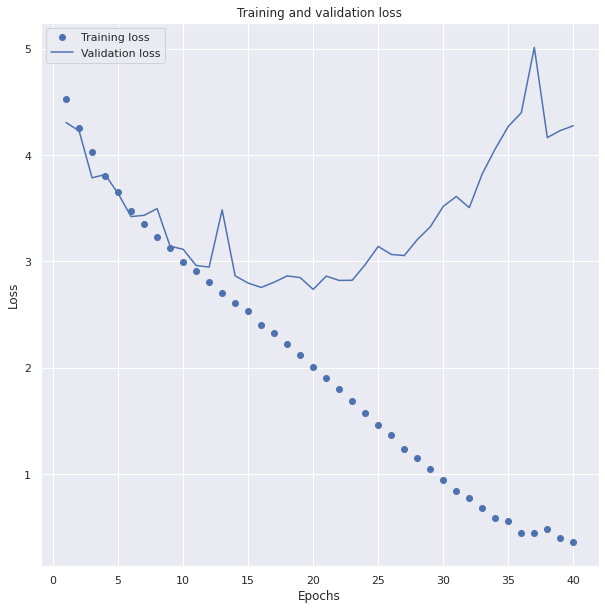

In [129]:
draw_loss_graph()

<Figure size 432x288 with 0 Axes>

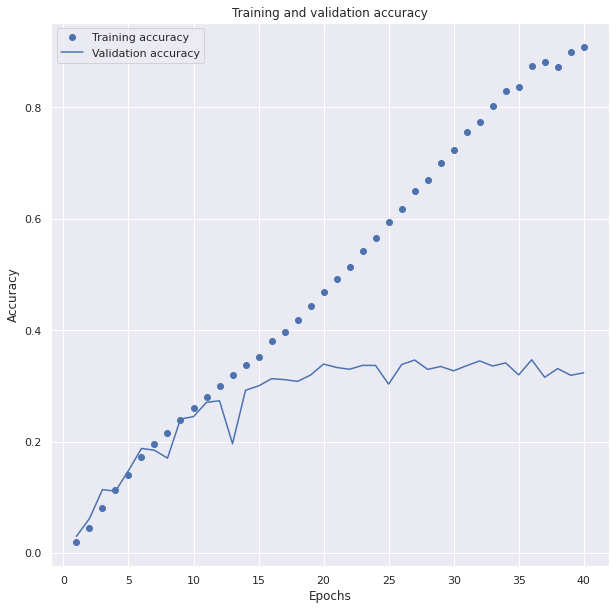

In [130]:
draw_accuracy_graph()

### 1.7 Regularizing the model and tuning hyper parameters

To generalize the model and combat the overfitting, I attempted the following strategies:

1. I added dropout layers to the architectures at different intervals
2. The architecture was slightly adjusted to have fewer layers
3. L2 regularization was added
4. Hyperparameters, such as the number of epochs and learning rates were tuned to improve the overfitting and the performance.


In [10]:
from keras import regularizers
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='softmax'))

In [11]:
from keras import optimizers

model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

In [12]:
history = model.fit(partial_x_train,
partial_y_train,
epochs=40,
batch_size=1000,
validation_data=(x_val, y_val))

Epoch 1/40
45/45 [==============================] - 2s 49ms/step - loss: 4.7080 - accuracy: 0.0244 - val_loss: 4.5346 - val_accuracy: 0.0480
Epoch 2/40
45/45 [==============================] - 2s 44ms/step - loss: 4.3484 - accuracy: 0.0481 - val_loss: 4.3429 - val_accuracy: 0.0594
Epoch 3/40
45/45 [==============================] - 2s 44ms/step - loss: 4.1312 - accuracy: 0.0773 - val_loss: 4.0127 - val_accuracy: 0.1234
Epoch 4/40
45/45 [==============================] - 2s 44ms/step - loss: 3.9246 - accuracy: 0.1075 - val_loss: 3.9706 - val_accuracy: 0.1152
Epoch 5/40
45/45 [==============================] - 2s 44ms/step - loss: 3.7954 - accuracy: 0.1314 - val_loss: 3.8371 - val_accuracy: 0.1498
Epoch 6/40
45/45 [==============================] - 2s 44ms/step - loss: 3.6650 - accuracy: 0.1539 - val_loss: 3.7538 - val_accuracy: 0.1598
Epoch 7/40
45/45 [==============================] - 2s 44ms/step - loss: 3.5648 - accuracy: 0.1698 - val_loss: 3.6465 - val_accuracy: 0.1866
Epoch 8/40
45

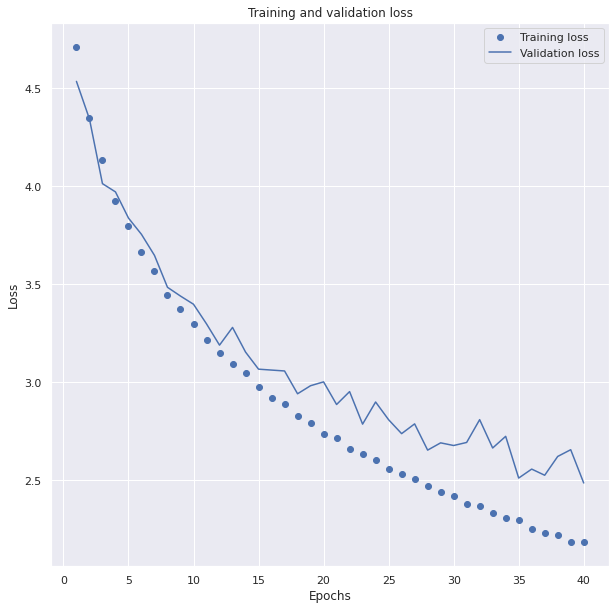

In [16]:
draw_loss_graph()

<Figure size 432x288 with 0 Axes>

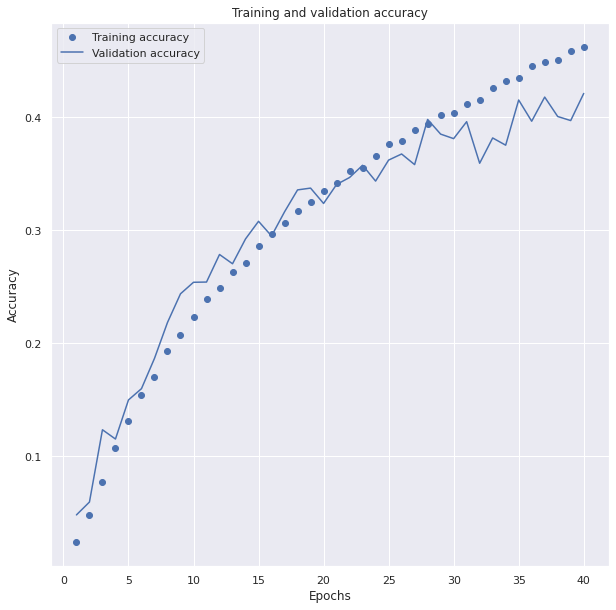

In [17]:
draw_accuracy_graph()

In [18]:
model.save('regularized_custom_cnn.h5')

In [7]:
from keras import models

model = models.load_model('regularized_custom_cnn.h5')

In [8]:
# Evaluation of test dataset using the regularized custom model
scores = model.evaluate(test_images_processed, one_hot_test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 2.4440 - accuracy: 0.4392


## 2. Transfer Learning Implementation

### 2.1 VGG16 architecture

Using Keras's prepackaged model to build a model. I decided to use the VCG16 model.

In [8]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(32, 32, 3))

Adding a densely connected classifier on top of the convolutional base

In [10]:
from keras import models
from keras import layers
from keras import regularizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='softmax'))

In [11]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
loss='categorical_crossentropy',
metrics=['accuracy'])

In [12]:
history = model.fit(partial_x_train,
partial_y_train,
epochs=40,
batch_size=1000,
validation_data=(x_val, y_val))

Epoch 1/40
45/45 [==============================] - 13s 282ms/step - loss: 5.0937 - accuracy: 0.0102 - val_loss: 5.0381 - val_accuracy: 0.0136
Epoch 2/40
45/45 [==============================] - 13s 284ms/step - loss: 4.9863 - accuracy: 0.0169 - val_loss: 4.8236 - val_accuracy: 0.0274
Epoch 3/40
45/45 [==============================] - 13s 292ms/step - loss: 4.8028 - accuracy: 0.0429 - val_loss: 4.5305 - val_accuracy: 0.0798
Epoch 4/40
45/45 [==============================] - 13s 298ms/step - loss: 4.4969 - accuracy: 0.0888 - val_loss: 4.3601 - val_accuracy: 0.1080
Epoch 5/40
45/45 [==============================] - 14s 303ms/step - loss: 4.1468 - accuracy: 0.1487 - val_loss: 3.7770 - val_accuracy: 0.2190
Epoch 6/40
45/45 [==============================] - 14s 306ms/step - loss: 3.6981 - accuracy: 0.2177 - val_loss: 3.5639 - val_accuracy: 0.2370
Epoch 7/40
45/45 [==============================] - 14s 309ms/step - loss: 3.3278 - accuracy: 0.2758 - val_loss: 2.9683 - val_accuracy: 0.3298

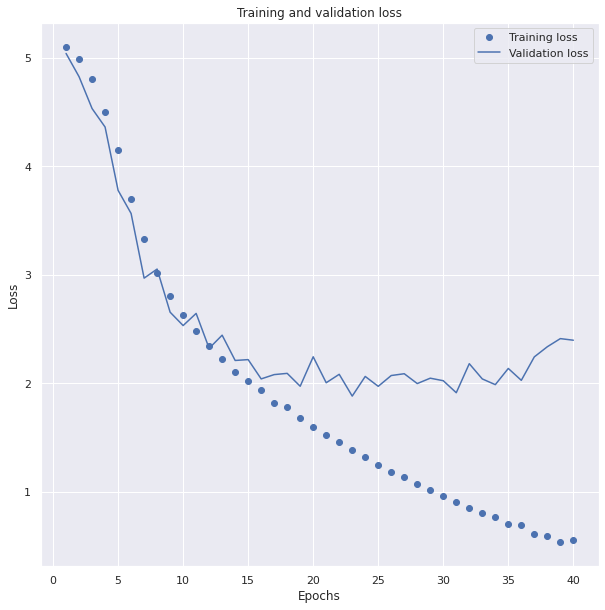

In [13]:
draw_loss_graph()

<Figure size 432x288 with 0 Axes>

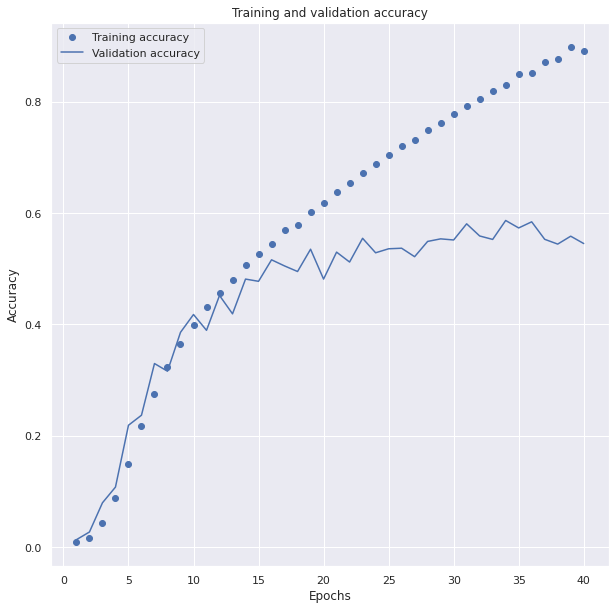

In [14]:
draw_accuracy_graph()

### 2.2 Freezing all layers

In [22]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(32, 32, 3))

conv_base.trainable = False

In [23]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='softmax'))

In [24]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
loss='categorical_crossentropy',
metrics=['accuracy'])

In [25]:
history = model.fit(partial_x_train,
partial_y_train,
epochs=60,
batch_size=1000,
validation_data=(x_val, y_val))

Epoch 1/60
45/45 [==============================] - 5s 108ms/step - loss: 5.1838 - accuracy: 0.0194 - val_loss: 4.8721 - val_accuracy: 0.0592
Epoch 2/60
45/45 [==============================] - 5s 102ms/step - loss: 4.8590 - accuracy: 0.0529 - val_loss: 4.6192 - val_accuracy: 0.1222
Epoch 3/60
45/45 [==============================] - 5s 102ms/step - loss: 4.6040 - accuracy: 0.0934 - val_loss: 4.3891 - val_accuracy: 0.1628
Epoch 4/60
45/45 [==============================] - 5s 102ms/step - loss: 4.3929 - accuracy: 0.1225 - val_loss: 4.1806 - val_accuracy: 0.1920
Epoch 5/60
45/45 [==============================] - 5s 102ms/step - loss: 4.2110 - accuracy: 0.1476 - val_loss: 4.0042 - val_accuracy: 0.2138
Epoch 6/60
45/45 [==============================] - 5s 103ms/step - loss: 4.0596 - accuracy: 0.1653 - val_loss: 3.8608 - val_accuracy: 0.2286
Epoch 7/60
45/45 [==============================] - 5s 103ms/step - loss: 3.9339 - accuracy: 0.1817 - val_loss: 3.7430 - val_accuracy: 0.2420
Epoch 

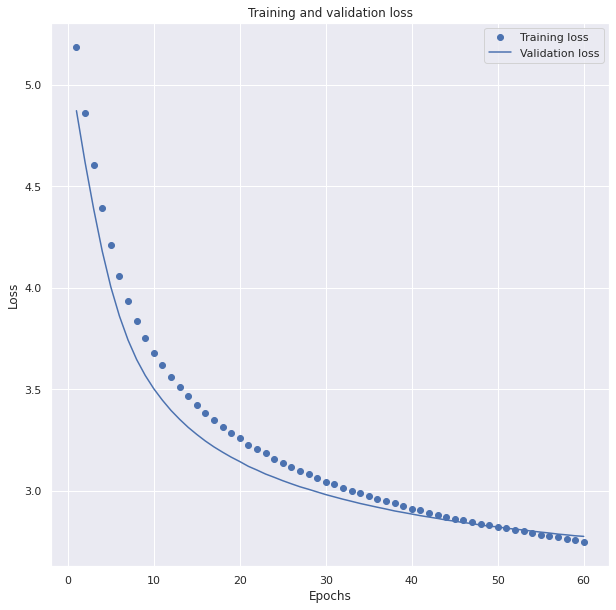

In [26]:
draw_loss_graph()

<Figure size 432x288 with 0 Axes>

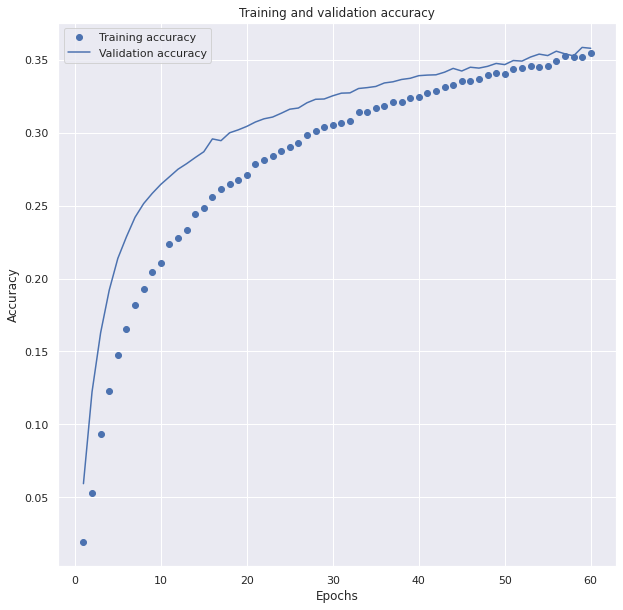

In [27]:
draw_accuracy_graph()

### 2.3 Freezing some layers

In [7]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(32, 32, 3))

conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [8]:
from keras import models
from keras import layers
from keras import regularizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='softmax'))

In [9]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
loss='categorical_crossentropy',
metrics=['accuracy'])

In [10]:
history = model.fit(partial_x_train,
partial_y_train,
epochs=40,
batch_size=1000,
validation_data=(x_val, y_val))

Epoch 1/40
45/45 [==============================] - 6s 128ms/step - loss: 4.6145 - accuracy: 0.0974 - val_loss: 3.8261 - val_accuracy: 0.2304
Epoch 2/40
45/45 [==============================] - 6s 125ms/step - loss: 3.8122 - accuracy: 0.2200 - val_loss: 3.2802 - val_accuracy: 0.3200
Epoch 3/40
45/45 [==============================] - 6s 126ms/step - loss: 3.4046 - accuracy: 0.2859 - val_loss: 3.0152 - val_accuracy: 0.3566
Epoch 4/40
45/45 [==============================] - 6s 126ms/step - loss: 3.1301 - accuracy: 0.3345 - val_loss: 2.8333 - val_accuracy: 0.3898
Epoch 5/40
45/45 [==============================] - 6s 127ms/step - loss: 2.9302 - accuracy: 0.3696 - val_loss: 2.7603 - val_accuracy: 0.3992
Epoch 6/40
45/45 [==============================] - 6s 127ms/step - loss: 2.7664 - accuracy: 0.3994 - val_loss: 2.6289 - val_accuracy: 0.4170
Epoch 7/40
45/45 [==============================] - 6s 127ms/step - loss: 2.6323 - accuracy: 0.4277 - val_loss: 2.5548 - val_accuracy: 0.4354
Epoch 

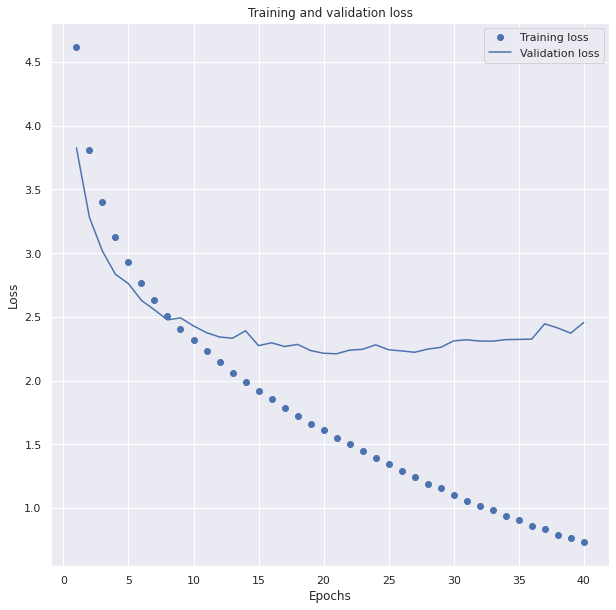

In [11]:
draw_loss_graph()

<Figure size 432x288 with 0 Axes>

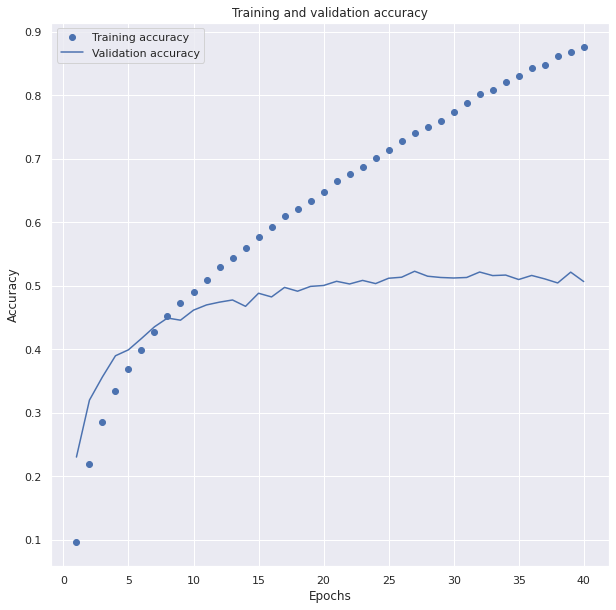

In [12]:
draw_accuracy_graph()

### 2.4 Default VGG model with different optimizer (Adam)


In [13]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(32, 32, 3))

In [14]:
from keras import models
from keras import layers
from keras import regularizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='softmax'))

In [15]:
from keras import optimizers

model.compile(optimizer=optimizers.Adam(lr=1e-4),
loss='categorical_crossentropy',
metrics=['accuracy'])

In [16]:
history = model.fit(partial_x_train,
partial_y_train,
epochs=40,
batch_size=1000,
validation_data=(x_val, y_val))

Epoch 1/40
45/45 [==============================] - 13s 286ms/step - loss: 4.9715 - accuracy: 0.0375 - val_loss: 4.4635 - val_accuracy: 0.1090
Epoch 2/40
45/45 [==============================] - 13s 290ms/step - loss: 4.2052 - accuracy: 0.1469 - val_loss: 3.5420 - val_accuracy: 0.2574
Epoch 3/40
45/45 [==============================] - 13s 293ms/step - loss: 3.4444 - accuracy: 0.2700 - val_loss: 2.9369 - val_accuracy: 0.3602
Epoch 4/40
45/45 [==============================] - 13s 295ms/step - loss: 2.9088 - accuracy: 0.3654 - val_loss: 2.5565 - val_accuracy: 0.4408
Epoch 5/40
45/45 [==============================] - 13s 299ms/step - loss: 2.5034 - accuracy: 0.4426 - val_loss: 2.3256 - val_accuracy: 0.4812
Epoch 6/40
45/45 [==============================] - 14s 302ms/step - loss: 2.2140 - accuracy: 0.5033 - val_loss: 2.1801 - val_accuracy: 0.5062
Epoch 7/40
45/45 [==============================] - 14s 305ms/step - loss: 1.9884 - accuracy: 0.5520 - val_loss: 2.0637 - val_accuracy: 0.5280

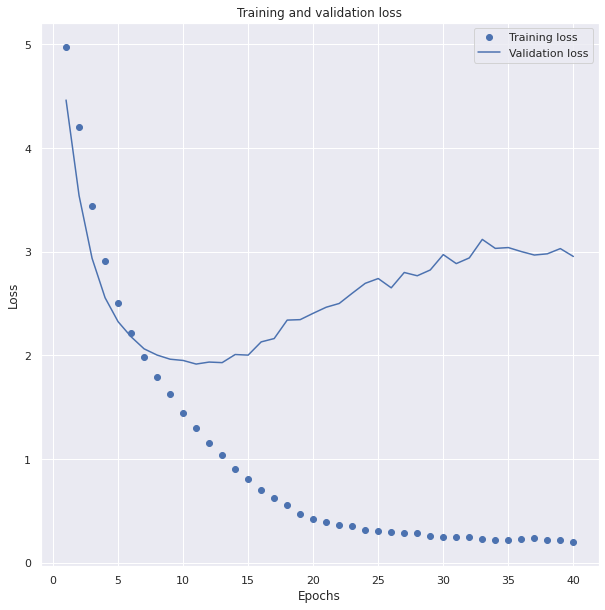

In [21]:
draw_loss_graph()

<Figure size 432x288 with 0 Axes>

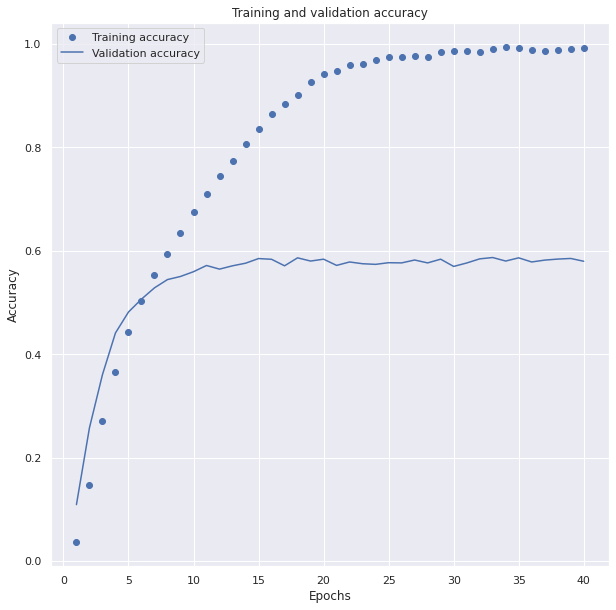

In [22]:
draw_accuracy_graph()

### 2.5 Default ResNet model

For the comparison of different base models, I implemented a model using the ResNet50 architecture. The additional layers built on top of the base ResNet layer was similar to the one for the VGG16 model, and other factors like regularization and hyperparameters were comparable as well.


In [18]:
from keras.applications import ResNet50
conv_base = ResNet50(weights='imagenet',
include_top=False,
input_shape=(32, 32, 3))

94773248/94765736 [==============================] - 0s 0us/step


In [19]:
from keras import models
from keras import layers
from keras import regularizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='softmax'))

In [20]:
from keras import optimizers

model.compile(optimizer=optimizers.Adam(lr=1e-4),
loss='categorical_crossentropy',
metrics=['accuracy'])

In [21]:
history = model.fit(partial_x_train,
partial_y_train,
epochs=30,
batch_size=1000,
validation_data=(x_val, y_val))

Epoch 1/30
45/45 [==============================] - 16s 348ms/step - loss: 5.8434 - accuracy: 0.0236 - val_loss: 33.2031 - val_accuracy: 0.0096
Epoch 2/30
45/45 [==============================] - 15s 338ms/step - loss: 5.1302 - accuracy: 0.0800 - val_loss: 7.4680 - val_accuracy: 0.0106
Epoch 3/30
45/45 [==============================] - 15s 341ms/step - loss: 4.7120 - accuracy: 0.1510 - val_loss: 7.2570 - val_accuracy: 0.0124
Epoch 4/30
45/45 [==============================] - 15s 343ms/step - loss: 4.2523 - accuracy: 0.2298 - val_loss: 6.2734 - val_accuracy: 0.0120
Epoch 5/30
45/45 [==============================] - 15s 343ms/step - loss: 3.7645 - accuracy: 0.3096 - val_loss: 6.1528 - val_accuracy: 0.0106
Epoch 6/30
45/45 [==============================] - 15s 342ms/step - loss: 3.2436 - accuracy: 0.3981 - val_loss: 5.5057 - val_accuracy: 0.0184
Epoch 7/30
45/45 [==============================] - 15s 341ms/step - loss: 2.7669 - accuracy: 0.4899 - val_loss: 5.4905 - val_accuracy: 0.015

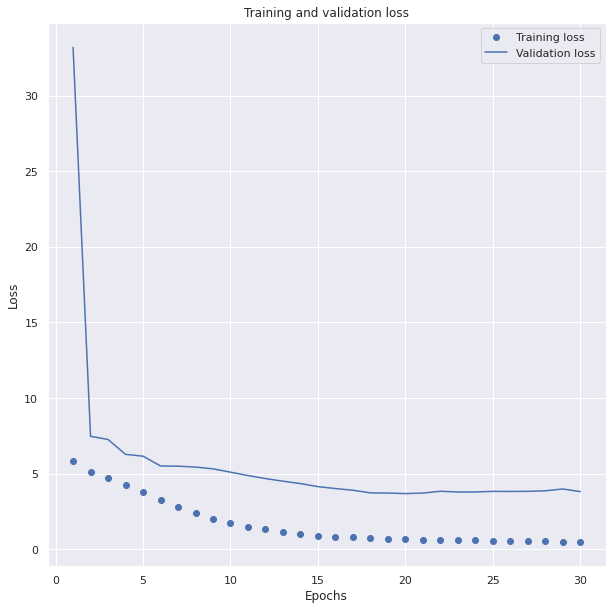

In [25]:
draw_loss_graph()

<Figure size 432x288 with 0 Axes>

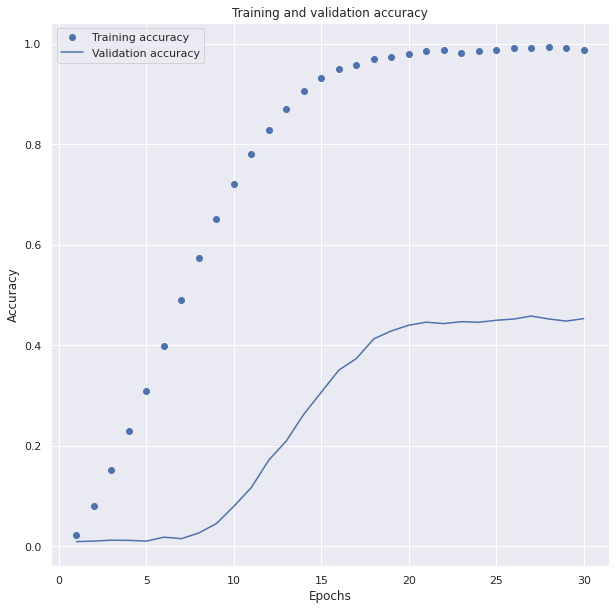

In [30]:
draw_accuracy_graph()

### 2.6 Optimal VGG model with additional regularization efforts

For my final optimal model using transfer learning, I decided to use the VGG16 architecture without any frozen layers  as the base since it gave me the best initial result. I further tried different hyperparameters such as the optimizer type, learning rate, number of epochs, batch size and so on. This optimal model performed fairly well, providing a testing accuracy of 57.7%, comparable to the maximum validation accuracy I attained in the course of this project.

In [7]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(32, 32, 3))

In [8]:
from keras import models
from keras import layers
from keras import regularizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='softmax'))

In [9]:
from keras import optimizers

model.compile(optimizer=optimizers.Adam(lr=1e-4),
loss='categorical_crossentropy',
metrics=['accuracy'])

In [10]:
history = model.fit(partial_x_train,
partial_y_train,
epochs=12,
batch_size=1000,
validation_data=(x_val, y_val))

Epoch 1/12
45/45 [==============================] - 13s 290ms/step - loss: 9.1768 - accuracy: 0.0423 - val_loss: 8.2677 - val_accuracy: 0.1348
Epoch 2/12
45/45 [==============================] - 13s 293ms/step - loss: 7.6929 - accuracy: 0.1587 - val_loss: 6.6740 - val_accuracy: 0.3054
Epoch 3/12
45/45 [==============================] - 13s 295ms/step - loss: 6.4444 - accuracy: 0.2817 - val_loss: 5.6583 - val_accuracy: 0.3868
Epoch 4/12
45/45 [==============================] - 13s 298ms/step - loss: 5.5268 - accuracy: 0.3736 - val_loss: 4.9905 - val_accuracy: 0.4372
Epoch 5/12
45/45 [==============================] - 13s 300ms/step - loss: 4.8180 - accuracy: 0.4435 - val_loss: 4.4631 - val_accuracy: 0.4814
Epoch 6/12
45/45 [==============================] - 14s 302ms/step - loss: 4.2659 - accuracy: 0.4927 - val_loss: 4.0676 - val_accuracy: 0.5030
Epoch 7/12
45/45 [==============================] - 14s 304ms/step - loss: 3.7934 - accuracy: 0.5389 - val_loss: 3.7376 - val_accuracy: 0.5182

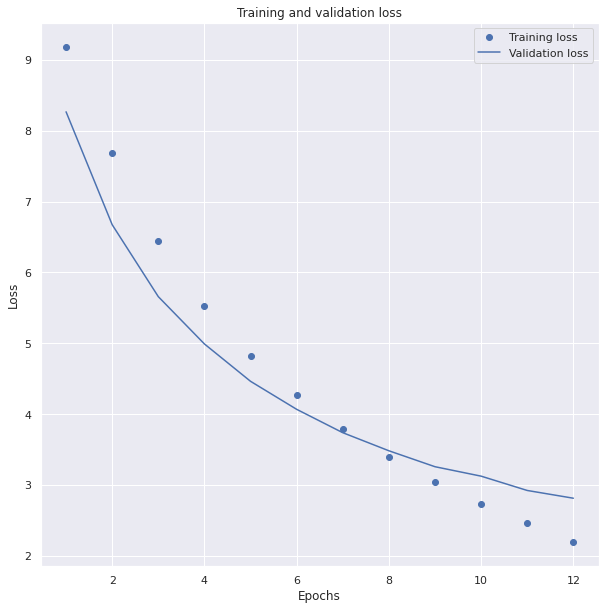

In [14]:
draw_loss_graph()

<Figure size 432x288 with 0 Axes>

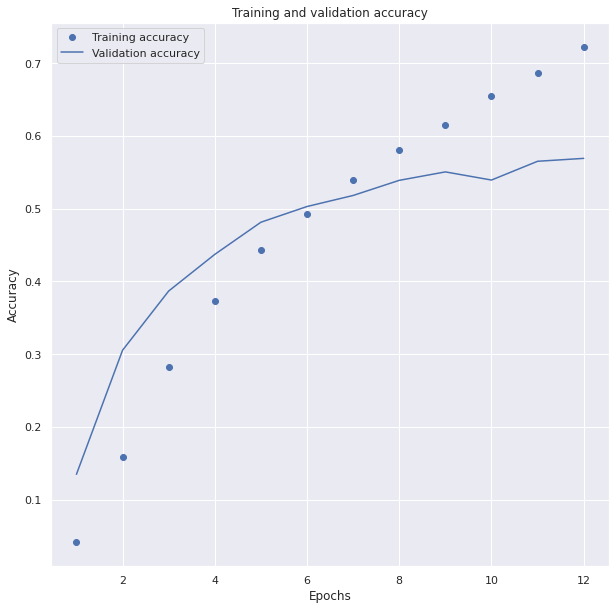

In [15]:
draw_accuracy_graph()

In [46]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               51300     
Total params: 15,028,644
Trainable params: 15,028,644
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.save("optmized_vgg.h5")

In [47]:
scores = model.evaluate(test_images_processed, one_hot_test_labels)

313/313 [==============================] - 2s 8ms/step - loss: 2.8071 - accuracy: 0.5776


In [48]:
scores

[2.8070991039276123, 0.5776000022888184]

In [49]:
 model.metrics_names

['loss', 'accuracy']

## 3. Visualizing Intermediate Activations

Following the technique from section 5.4 from the textbook, I visualized the intermediate activations. This allowed me to observe and understand the successive layers and how they transform the input. We can also analyze how the input decomposed into the different filters learned by the network

### 3.1 Loading model and preparing test image

In [33]:
from keras import models

model = models.load_model('regularized_custom_cnn.h5')

model.summary()

# Extracting top 8 layers
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       36992     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 128)         0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 128)        

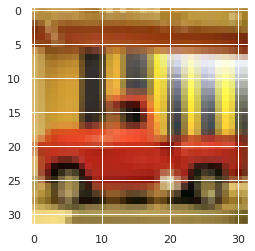

In [26]:
# Input Image
img = x_test[47]
plt.imshow(img)
plt.show()

In [34]:
# Preprocessing the image
img = img / 255.
img_tensor = np.expand_dims(img, axis=0)
print(img_tensor.shape)
activations = activation_model.predict(img_tensor)

(1, 32, 32, 3)


### 3.2 Visualizations 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


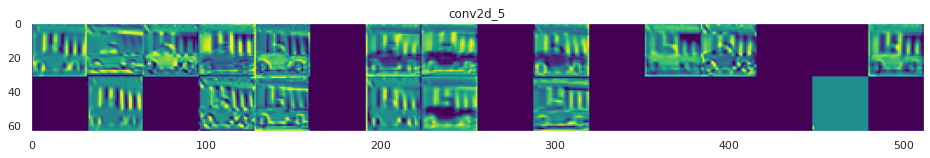

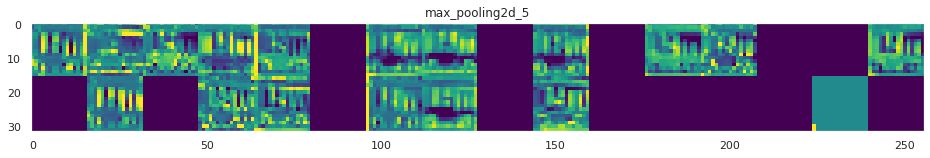

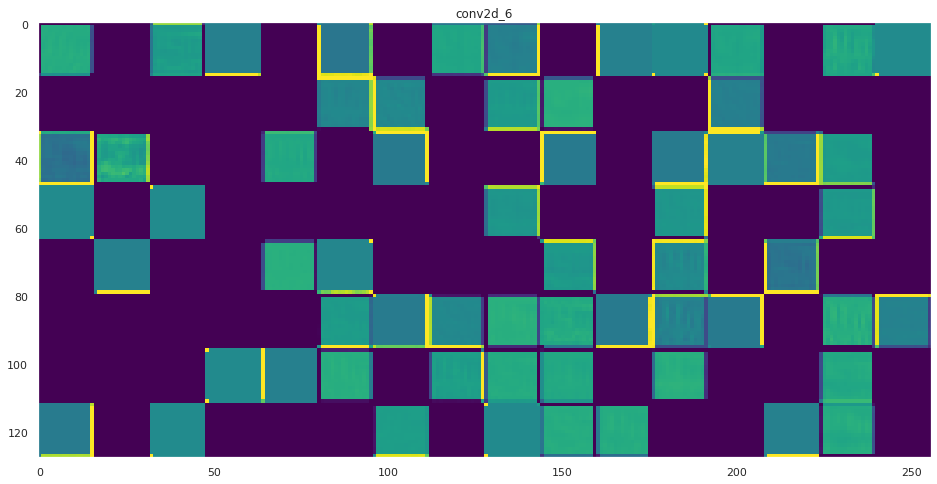

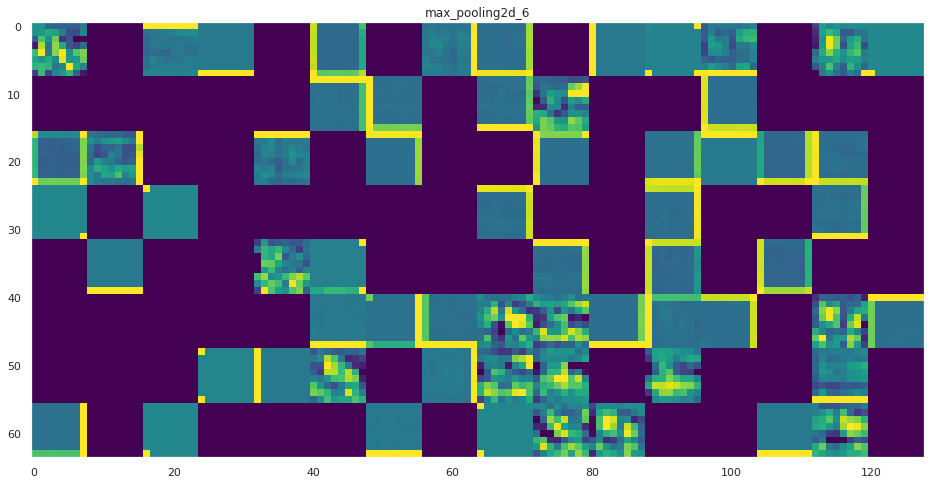

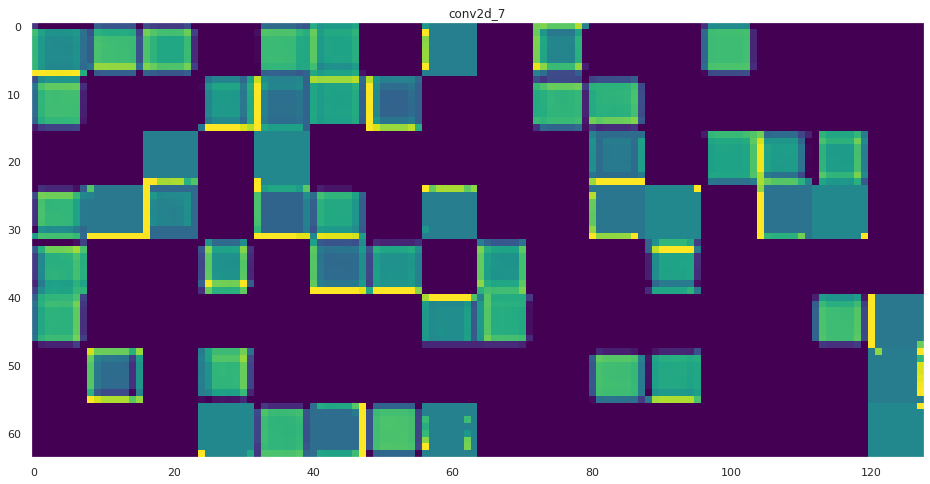

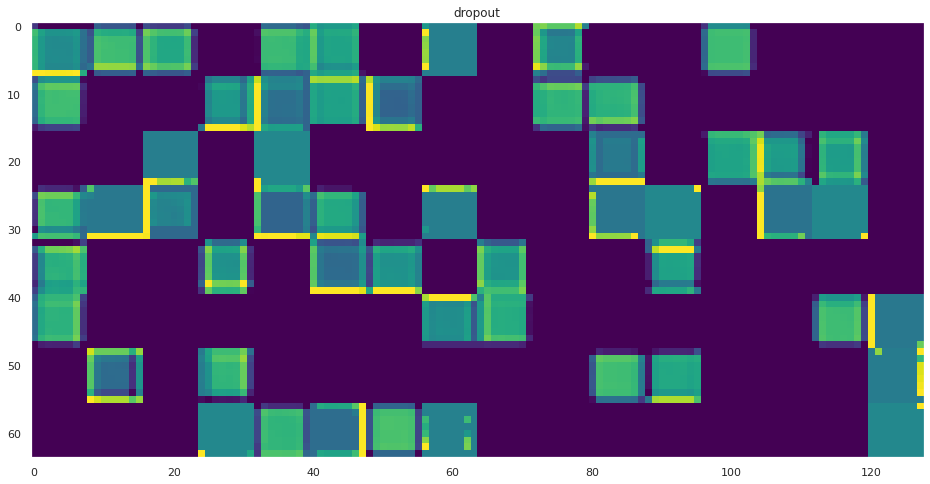

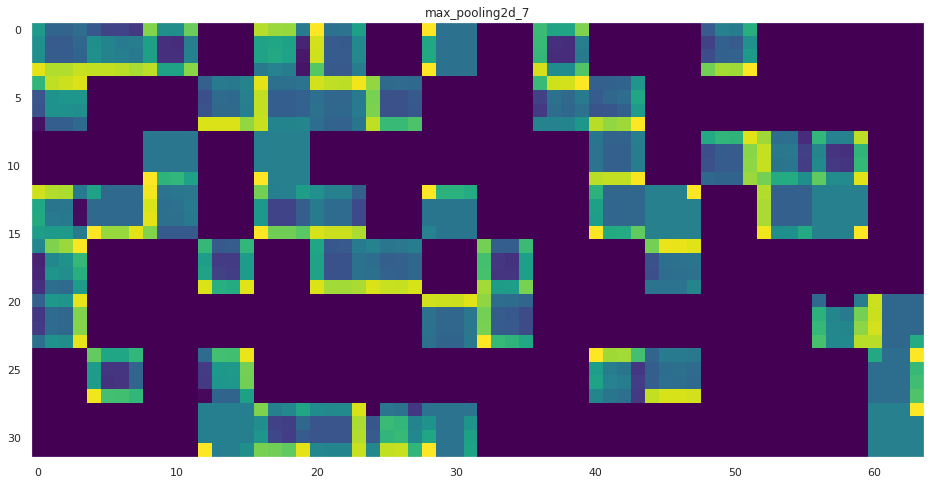

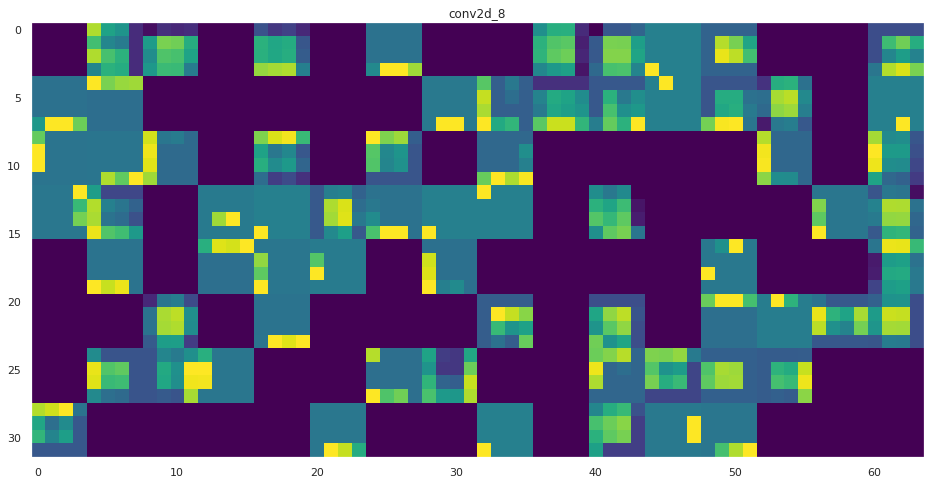

In [35]:
layer_names = []

for layer in model.layers[:8]:
    layer_names.append(layer.name) # Name of each layer
    images_per_row = 16
    
    # Displaying feature maps
    for layer_name, layer_activation in zip(layer_names, activations):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                :, :,
                col * images_per_row + row]
                
                # Post-processes the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
                    
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
    scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')